Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE", as well as your name and collaborators below:

In [1]:
NAME = "Nikolai Lyssogor"
COLLABORATORS = ""

---

<a id="top"></a>
   
# CSCI 3202 : Assignment 7

Topics in this assignment:
  - Hidden Markov Models: Definition, Operation of HMM
  - Filtering: What is filtering? Belief States. Forward Propagation of belief states. Conditioning Belief States on evidence.
  
Shortcuts:  [top](#top) | [1](#p1) | [2](#p2) | [bottom](#bottom)
  

<a id="p1"></a>

# Problem 1 

In this problem, we ask you to code up a data structure in python for representing a HMM. The main fields of this data structure are as follows:
  - `n`: number of states
  - `state_information`: A list of "extra information" about each state. Must be of size `n`.
  - `ev_labels`: a list of evidence labels.
  - `transition_prob`: A list of `n` elements where each element 
    - `transition_prob[i]` is a dictionary that maps `{...,j:Pij,...}` where `Pij` is the probability of going from `i` to `j`. 
    - If state `j` does not appear in the dictionary `transition_prob[i]` then the probability of transitioning from `i` to `j` is `0`.
  - `evidence_prob`: A list of `n` elements where each element: 
    - `evidence_prob[i]` is a dictionary `{..., ev_label_j: Qij,...}` that maps from `ev_label_j` (an evidence label) to the probability `Qij`. 
    - If a particular evidence label does not appear in this dictionary, then the probability is taken to be `0`.
    
Functions to implement below:
  - `propagate_belief_state`
  - `condition_belief_state`

In [2]:
import random
import copy

class HMM:
    def __init__(self, n, state_info_list, ev_labels_list):
        self.n = n
        self.state_information = state_info_list
        self.ev_labels = ev_labels_list
        
        # View transition_prob as an adjacency representation where we are storing for 
        # each state i, self.transition_prob[i] that is a dictionary to all states j and 
        # probability of going from i to j
        self.transition_prob = [ {} for i in range(self.n)]
        # Initialize all evidence labels to 0.0
        self.evidence_prob = [{} for i in range(self.n)]
    
    # Function: set_transition_probability
    # Set the probability of going from state i to state j in the
    # Markov chain part of the HMM to pij
    def set_transition_probability(self, i, j, pij):
        assert 0 <= i < self.n
        assert 0 <= j < self.n
        assert 0.0 <= pij <= 1.0
        tp_adj_dict = self.transition_prob[i]
        tp_adj_dict[j] = pij
        
    # Function: set_evidence_probability
    # Set the probability of getting evidencelabel ev_lab from state i 
    # to qij
    def set_evidence_probability(self, i, ev_lab, qij):
        assert 0 <= i < self.n
        assert 0 <= qij <= 1.0
        assert ev_lab in self.ev_labels
        ep_adj_dict = self.evidence_prob[i]
        ep_adj_dict[ev_lab] = qij
    
    def probability_check(self, prob_repr):
        return (all(pj >= 0 for (_, pj) in prob_repr.items()) and 
                abs(sum([pj for (_, pj) in prob_repr.items()]) - 1.0) <= 1E-8)
    
    def check_HMM(self):
        # Check that probabilities of outgoing edges from a state are all >= 0 and
        # add up to 1.
        # Check that the evidence labels from each state have probabilities
        # that add up to 1.
        for i in range(self.n):
            assert self.probability_check(self.transition_prob[i]), f'Fatal: Probabilities for outgoing edges state: {self.state_information[i]}({i}) are incorrect'
            assert self.probability_check(self.evidence_prob[i]), f'Fatal: Probabilities for all evidence labels state {self.state_information[i]}({i}) are incorrect'
        return True 
    
    # Function: Uniform belief state
    # Return a list of n probabilities all of which are 1/n
    def uniform_belief_state(self):
        return [1.0/self.n]*self.n
    
    # Function: Check belief state
    # Check all entries are >= 0 and that they add up to 1.0
    def check_belief_state(self, bstate):
        return all(pj >= 0 for pj in bstate) and abs(sum(bstate)-1.0) <= 1E-8
    
    def get_transition_prob(self, i, j):
        assert 0 <= i < self.n
        assert 0 <= j < self.n
        tp_dict = self.transition_prob[i]
        return tp_dict[j] if j in tp_dict else 0.0
    
    def get_evidence_prob(self, i, ev_lab):
        assert 0 <= i < self.n
        assert ev_lab in self.ev_labels
        tp_dict = self.evidence_prob[i]
        return tp_dict[ev_lab] if ev_lab in tp_dict else 0.0
        
    # Function: propagate_belief_state
    # Given a belief state [p1, p2, ..., pn] Compute the belief state if the chain is 
    # allowed to evolve one step: [p1',..., pn'] where pj' = sum( pi * Pij), 
    # Pij is probability of going from i to j
    # return new belief state (list of n numbers that must be >= 0 and add up to 1)
    # Estimated length: ~ 7 lines of code
    def propagate_belief_state(self, old_state):
        
        # YOUR CODE HERE
        new_state = copy.deepcopy(old_state)
        for i in range(len(old_state)):
            acc = 0
            for j in range(len(old_state)):
                acc += old_state[j]*self.get_transition_prob(j, i)
            new_state[i] = acc
        
        return new_state                
                
    #Function: Condition Belief State on a given evidence label
    # Given a belief state: [p1,...,pn] and an evidence label ev_lab
    # Condition the belief state by calculating pj' = pj * Q(j, ev_lab) 
    # Do not forget to normalize the resulting belief state [p1',...,pn'] so that its probabilities
    # sum up to 1 once more.
    # Estimated length: < 10 lines of code
    def condition_belief_state(self, bstate, ev_lab):
        
        # YOUR CODE HERE
        for i in range(len(bstate)):
            bstate[i] *= self.get_evidence_prob(i, ev_lab)
            
        return [belief/sum(bstate) for belief in bstate]
    
    def one_step_filter(self,   cur_state, cur_ev_lab):
        state0 = self.propagate_belief_state(cur_state)
        state1 = self.condition_belief_state(state0, cur_ev_lab)
        return state1
    
    def sample_from_categorical(self, prob_dic):
        values = [j for j in prob_dic.keys()]
        prob = [p for (_,p) in prob_dic.items()]
        return random.choices(values, weights=prob)
    
    def sample_next_state(self, cur_state):
        prob_dic = self.transition_prob[cur_state]
        return self.sample_from_categorical(prob_dic)
    
    def sample_evidence(self, cur_state):
        prob_dic = self.evidence_prob[cur_state]
        return self.sample_from_categorical(prob_dic)
    
    def sample_hmm_states(self, init_state, n_steps):
        state_trace = [init_state]*(n_steps+1)
        state_trace[0] = init_state
        evidence_trace = [None]*(n_steps+1)
        for time in range(n_steps):
            cur_state = state_trace[time]
            [next_state] = self.sample_next_state(cur_state)
            [next_evidence] = self.sample_evidence(next_state)
            state_trace[time+1] = next_state
            evidence_trace[time+1] = next_evidence
        return (state_trace, evidence_trace)
      
        

In [3]:
## BEGIN TESTS

# Construct the example HMM from book and covered in lecture
hmm = HMM(2, ['Rainy', 'Sunny'], ['+U','-U'])
hmm.set_transition_probability(0, 1, 0.3)
hmm.set_transition_probability(0,0, 0.7)
hmm.set_transition_probability(1, 0, 0.3)
hmm.set_transition_probability(1,1, 0.7)
hmm.set_evidence_probability(0, '+U', 0.9)
hmm.set_evidence_probability(0, '-U', 0.1)
hmm.set_evidence_probability(1, '+U', 0.2)
hmm.set_evidence_probability(1, '-U', 0.8)
hmm.check_HMM()

#Test whether belief states are being propagated correctly
s0 = hmm.uniform_belief_state()
print(f's0 = {s0}')

## FIRST STEP
s10 = hmm.propagate_belief_state(s0)
print(f's10 = {s10}')
assert(s10[0] == 0.5), 'A: Propagation of belief state failed'
assert(s10[1] == 0.5), 'B: Propagation of belief state failed'
s1 = hmm.condition_belief_state(s10, '+U')
print(f's1 = {s1}')
assert(abs(s1[0] - 9/11) <= 1E-3), f'C: Expected value 0.818181. Your code returned {s1[0]}'
assert(abs(s1[1] - 2/11) <= 1E-3),f'D: Expected value 0.1818181. Your code returned {s1[1]}'

## SECOND STEP
#s2 = hmm.one_step_filter(s1, '+U')
s20 = hmm.propagate_belief_state(s1)
print(f's20 = {s20}')
assert(abs(s20[0] - (9/11*7/10+2/11*3/10)) <= 1E-3), f'E: Expected value: 0.6272727, your code returned: {s20[0]}'
assert(abs(s20[1] - (9/11*3/10+2/11*7/10)) <= 1E-3), f'F: Expected value: 0.3727272, your code returned: {s20[1]}'
s2 = hmm.condition_belief_state(s20, '+U')
print(f's2 = {s2}')
assert(abs(s2[0] - 0.88335704) <= 1E-3), f'G: Expected value: 0.88335704, your code returned {s2[0]}'
assert hmm.check_belief_state(s2), f'H: s2 = {s2} is not a proper belief state'

##THIRD STEP
s3 = hmm.one_step_filter(s2, '+U')
print(f's3 = {s3}')
assert hmm.check_belief_state(s3), f'I: s3 = {s3} is not a proper belief state'
assert abs(s3[0]- 0.89452727) <= 1E-4, f'J: Expected: 0.89452727, your code returned: {s3[0]}'

## FOURTH STEP
s4 = hmm.one_step_filter(s3, '-U')
print(f's4 = {s4}')
assert hmm.check_belief_state(s4), f'K: s4 = {s4} is not a proper belief state'
assert abs(s4[0]- 0.193740268) <= 1E-4, f'L: Expected: 0.193740268, your code returned: {s4[0]}'

## FIFTH STEP
s5 = hmm.one_step_filter(s4, '-U')
print(f's5 = {s5}')
assert hmm.check_belief_state(s5), f'M: s5 = {s5} is not a proper belief state'
assert abs(s5[0]- 0.0704608842) <= 1E-4, f'N: Expected: 0.0704608842, your code returned: {s5[0]}'

## SIXTH STEP
s6 = hmm.one_step_filter(s5, '-U')
print(f's6 = {s6}')
assert hmm.check_belief_state(s6), f'O: s6 = {s6} is not a proper belief state'
assert abs(s6[0]- 0.0575488462) <= 1E-4, f'P: Expected: 0.0575488462, your code returned: {s6[0]}'
print('Passed Test: 15 points.')
## END TESTS

s0 = [0.5, 0.5]
s10 = [0.5, 0.5]
s1 = [0.8181818181818181, 0.18181818181818182]
s20 = [0.6272727272727272, 0.3727272727272727]
s2 = [0.883357041251778, 0.1166429587482219]
s3 = [0.8945272770552466, 0.10547272294475342]
s4 = [0.1937402685637404, 0.8062597314362596]
s5 = [0.07046088427546517, 0.9295391157245348]
s6 = [0.057548846268140136, 0.94245115373186]
Passed Test: 15 points.


In [4]:
## BEGIN TESTS

# Construct the example HMM from book but modify probabilities 
hmm = HMM(2, ['Rainy', 'Sunny'], ['+U','-U'])
hmm.set_transition_probability(0, 1, 0.5)
hmm.set_transition_probability(0,0, 0.5)
hmm.set_transition_probability(1, 0, 0.3)
hmm.set_transition_probability(1,1, 0.7)
hmm.set_evidence_probability(0, '+U', 0.9)
hmm.set_evidence_probability(0, '-U', 0.1)
hmm.set_evidence_probability(1, '+U', 0.1)
hmm.set_evidence_probability(1, '-U', 0.9)
hmm.check_HMM()

# Test whether belief states are being propagated correctly
s0 = hmm.uniform_belief_state()
print(f's0 = {s0}')

## FIRST STEP
s10 = hmm.propagate_belief_state(s0)
print(f's10 = {s10}')
assert(s10[0] == 0.4), 'A: Propagation of belief state failed'
assert(s10[1] == 0.6), 'B: Propagation of belief state failed'
s1 = hmm.condition_belief_state(s10, '+U')
print(f's1 = {s1}')
assert(abs(s1[0] - 6/7) <= 1E-3), f'C: Expected value 0.8571428571. Your code returned {s1[0]}'
assert(abs(s1[1] - 1/7) <= 1E-3),f'D: Expected value 0.142857142. Your code returned {s1[1]}'

## SECOND STEP
#s2 = hmm.one_step_filter(s1, '+U')
s20 = hmm.propagate_belief_state(s1)
print(f's20 = {s20}')
assert(abs(s20[0] - (6/7 *1/2 +1/7*3/10)) <= 1E-3), f'E: Expected value: {33/70}, your code returned: {s20[0]}'
assert(abs(s20[1] - (6/7*1/2+1/7*7/10)) <= 1E-3), f'F: Expected value:{37/70}, your code returned: {s20[1]}'
s2 = hmm.condition_belief_state(s20, '+U')
print(f's2 = {s2}')
assert(abs(s2[0] - 33/70*0.9/(33/70*0.9 + 37/70*0.1)) <= 1E-3), f'G: Expected value: 0.889221, your code returned {s2[0]}'
assert hmm.check_belief_state(s2), f'H: s2 = {s2} is not a proper belief state'

print('Passed Test: 10 points.')

## END TESTS

s0 = [0.5, 0.5]
s10 = [0.4, 0.6]
s1 = [0.8571428571428572, 0.14285714285714285]
s20 = [0.4714285714285715, 0.5285714285714286]
s2 = [0.8892215568862275, 0.11077844311377244]
Passed Test: 10 points.


<a id="p2"></a>[Back to top](#top)

# Problem 2:  Water balloon tracking

Suppose you are walking down the street with your friend, when your sensors pick up a dangerous ***water balloon*** incoming! 

<img src="https://github.com/arpg/arpg.github.io/raw/master/img/waterballoon.png" style="width: 550px;"/>


To track the water balloon and update your assessment of the probabilities that you or your friend will be hit, you think fast and implement a Hidden Markov Model. Unfortunately, you and your friend are also so busy implementing this model that you don't simply move out of the way (i.e., assume you are both stationary throughout this problem).

Assume that all action in this problem happens within the bounds $-1 \leq x \leq 1$ and $0 \leq y \leq 20$.

<b>Discretization of Environment into Cells</b>
First, let us discretize the environment by using cells of width $\Delta x = 0.1$ meters and $\Delta y = 0.1$ meters.  
  - $i$ ranges from $0$ to $20$ (inclusive)
  - $j$ ranges from $0$ to $200$ (inclusive).
  - Cell number $(i,j)$ in the map refers to $(x,y)= (-1 + i \Delta x, j \Delta y)$.

<b>Baloon's Movement Towards You or Your Friend</b>

At each step, the Balloon moves from its current cell $(i,j)$ to next cell $(i',j')$ as follows:
  - If $j = 0$ then the balloon has landed "splat" someplace. $i' = i $ and $j' = 0$ with probability $1$.
  - If $j > 0$, then the balloon is still flying towards its unknown target:
    - After each time, the balloon's $y$ position always decreases by $0.1$. Therefore, $j' = j-1$.
    - Now, in addition to this constant movement towards you and your friend, the water balloon also experiences some random fluctuations in its $x$ coordinate along its path. If the balloon is in bin $i$ in time step $t$, then in time step $t+1$ the balloon is:
      * still on course: $i' = i$ with probability $0.7$,
      * in either of the adjacent bins ($i\pm 1$) with probability $0.1$, and
      * in either of the bins 2 away ($i\pm 2$) with probability $0.05$.
      * If in this process, the balloon's `i` coordinate is out of bounds, then it "wraps around". I.e, position $i'=-1$ becomes $i'=20$, $i' = -2$ becomes $i' = 19$ and so on. Likewise, $i' = 21$ becomes $i' = 0$, $i' = 22$ becomes $i' = 1$ and so on.


Your torso occupies the region $0 \le x \le 0.3$ and $y = 0$, and your friend occupies the region $0.4 \le x \le 0.7$ (also $y=0$). So there are exactly 3 bins that correspond to hitting you, and 3 that correspond to hitting your friend. When the balloon reaches $y=0$, if it is within either of these $x$ regions, then it will hit you or your friend. Otherwise, the balloon hits no on.

<b>Sensors</b>

Your sensors (i.e., perception) measures the baloon's $x$ position. They are not too  accurate or reliable. When you measure the balloon's x-position, if the water balloon is actually in bin $(i,j)$, then:
* The sensor returns the special value `"unknown"` 1/2 of the time,
* You get the current value of $i$ exactly correct 5/34 of the time,
* you measure bins $i\pm 1$ each with probability 3/34(note that wrap around applies here: i=-1 gets converted to i = 20 and so on, as described earlier),
* you measure bins $i\pm 2$ each with probability 2/34 (note: wrap around applies), and
* you measure bins $i\pm 3$ each with probability 1/34 (note: wrap around applies).

<br>

<b>Define a HMM model (hurry!)</b>

Let's set up the discretized environment as a HMM model. Note that your model should have 
$21 * 201 = 4221$ states. 
  - You should use the HMM structure in the previous problem.
  - You should use an efficient way to map each $(i,j)$ to a state $s$. We suggest using $ s = (i*201 + j)$.
  
What you need to implement for this problem:
- `__init__`
- `get_hmm_state`
- `get_hmm_coordinates`
- `add_next_state_transitions`
- `add_state_evidence_probabilities`

Remember you can define helper functions as needed!

In [5]:
class WaterBalloonModel(HMM):
    def __init__(self):
        # Initialize a super class HMM with 4221 states
        # Set the information for each state s to the corresponding coordinates
        # Set the evidence label
        # Estimated length: < 5 lines of code
        
        # YOUR CODE HERE
        # n, state_info_list, ev_labels_list
        ev_labels = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20] + ['unknown']
        state_info = [i for i in range(4221)]
        super().__init__(4221, state_info, ev_labels)
        
        
    # Function: get_hmm_state
    # Implement the mapping from coordinate (i,j) to a state 
    # index s between 0 and 4220 (inclusive)
    # Estimated length: < 5 lines of code
    def get_hmm_state(self, i, j):
        assert 0 <= i < 21
        assert 0 <= j < 201
        
        # YOUR CODE HERE
        return i*201+j
        
    # Function: get_hmm_coordinates
    # Implement the mapping from a state s back to the corr. coordinate (i,j)
    # Estimated length: 1 line of code!
    def get_hmm_coordinates(self, s):
        assert 0 <= s < 4221
        # YOUR CODE HERE
        return (int((s - s%201)/201), s%201)
        
    # Function: add_next_state_transitions
    # Implement the function that will add 
    # next state transitions and probabilities 
    # for the state (i,j).
    # Use the function self.set_transition_probability defined in the parent HMM class.
    # Make sure you convert state (i,j) to a HMM state using
    # get hmm state function.
    # Estimated length: < 15 lines of code
    def add_next_state_transitions(self, i, j):
        assert 0 <= i < 21
        assert 0 <= j < 201
        
        # YOUR CODE HERE
        curr_state = self.get_hmm_state(i,j)
        wrap = {-1:20, -2:19, 21:0, 22:1}
        
        if j == 0: # case where balloon has already hit the ground
            self.set_transition_probability(curr_state, curr_state, 1)
        else:
            self.set_transition_probability(curr_state, self.get_hmm_state(i, j-1), 0.7) # no lateral movement
            self.set_transition_probability(curr_state, self.get_hmm_state(wrap.get(i+1,i+1), j-1), 0.1) # moves 1 to the right
            self.set_transition_probability(curr_state, self.get_hmm_state(wrap.get(i-1,i-1), j-1), 0.1) # moves 1 to the left
            self.set_transition_probability(curr_state, self.get_hmm_state(wrap.get(i+2,i+2), j-1), 0.05) # moves 2 to the right
            self.set_transition_probability(curr_state, self.get_hmm_state(wrap.get(i-2,i-2), j-1), 0.05) # moves 2 to the left
        
    # Function: add_state_evidence_probabilities
    # Implement the function that will add 
    # evidence probabilities 
    # for the state (i,j).
    # Use the function self.set_state_evidence_probabilities defined in the parent HMM class.
    # Make sure you convert state (i,j) to a HMM state using
    # get hmm state function.
    # Estimated length: < 15 lines of code
    def add_state_evidence_probabilities(self, i, j):
        assert 0 <= i < 21
        assert 0 <= j < 201
        
        # YOUR CODE HERE
#         def set_evidence_probability(self, i, ev_lab, qij):
        curr_state = self.get_hmm_state(i, j)
        wrap = {-1:20, -2:19, -3:18, 21:0, 22:1, 23:2}
        
        self.set_evidence_probability(curr_state, 'unknown', 0.5)
        self.set_evidence_probability(curr_state, i, 5/34)
        self.set_evidence_probability(curr_state, wrap.get(i+1, i+1), 3/34)
        self.set_evidence_probability(curr_state, wrap.get(i-1, i-1), 3/34)
        self.set_evidence_probability(curr_state, wrap.get(i+2, i+2), 2/34)
        self.set_evidence_probability(curr_state, wrap.get(i-2, i-2), 2/34)
        self.set_evidence_probability(curr_state, wrap.get(i+3, i+3), 1/34)
        self.set_evidence_probability(curr_state, wrap.get(i-3, i-3), 1/34)
    
    # Function: build_hmm
    # Will build the HMM model using the functions you have provided
    # Will also run checks to make sure that a proper HMM is built.
    def build_hmm(self):
        for i in range(21):
            for j in range(201):
                self.add_next_state_transitions(i, j)
                self.add_state_evidence_probabilities(i, j)
        self.check_HMM()
    
    # Function: get_next_states
    # return the next states and probabilities
    # used in testing -- DO NOT MODIFY
    def get_next_states(self, i, j):
        s = self.get_hmm_state(i, j)
        trs = self.transition_prob[s]
        trs_mod = {self.get_hmm_coordinates(st):pj for (st, pj) in trs.items()}
        return trs_mod 
    
    # Function: get_evidence_labels
    # return the labels and probabilities
    # used in testing -- DO NOT MODIFY
    def get_evidence_labels(self, i, j):
        s = self.get_hmm_state(i, j)
        ev_prob = self.evidence_prob[s]
        return ev_prob
    
    # Function: initial_belief_state
    # start with an initial belief state that j = 200 and i is uniformly distributed between 0 and 20
    def initial_belief_state(self):
        bstate = [0.0]*4221
        j0 = 200
        for i in range(21):
            s = self.get_hmm_state(i, j0)
            bstate[s] = 1.0/20.0
        return bstate

    # Function: sample_trace
    # Generates a sample of trace and evidence
    def sample_trace(self, n_steps):
        init_state = self.get_hmm_state(10, 200)
        state_trace, ev_trace = self.sample_hmm_states(init_state, n_steps)
        coord_trace = [self.get_hmm_coordinates(sj) for sj in state_trace]
        return coord_trace, ev_trace
        

In [6]:
## BEGIN TESTS
wb = WaterBalloonModel()
wb.build_hmm()
trs = wb.get_next_states(10, 2)

print('Checking next states for (10,1)')
assert((10,1) in trs)
assert(trs[(10,1)] == 0.7)
assert((11,1) in trs)
assert(trs[(11,1)] == 0.1)
assert((9,1) in trs)
assert(trs[(9,1)] == 0.1)
assert((12,1) in trs)
assert(trs[(12,1)] == 0.05)
assert((8,1) in trs)
assert(trs[(8,1)] == 0.05)

print('Checking next states for (20,14) -- Are you wrapping around properly?')
trs2 = wb.get_next_states(20,14)
assert((20,13) in trs2)
assert(trs2[(20,13)] == 0.7)
assert((19,13) in trs2)
assert(trs2[(19,13)] == 0.1)
assert((0,13) in trs2)
assert(trs2[(0,13)] == 0.1)
assert((18,13) in trs2)
assert(trs2[(18,13)] == 0.05)
assert((1,13) in trs2)
assert(trs2[(1,13)] == 0.05)


print('Checking next states for (0,100) -- Are you wrapping around properly?')
trs3 = wb.get_next_states(0,100)
assert((0,99) in trs3)
assert(trs3[(0,99)] == 0.7)
assert((20,99) in trs3)
assert(trs3[(20,99)] == 0.1)
assert((1,99) in trs3)
assert(trs3[(1,99)] == 0.1)
assert((2,99) in trs3)
assert(trs3[(2,99)] == 0.05)
assert((19,99) in trs3)
assert(trs3[(19,99)] == 0.05)

print('Checking that you are handling next states when j = 0 correctly!')
for i in range(21):
    trs4 = wb.get_next_states(i,0)
    assert((i,0) in trs4)
    assert(trs4[(i,0)]== 1.0)
    
print('Checking evidence labels for state (10,99)')
ev0 = wb.get_evidence_labels(10, 99)
assert(ev0[10] == 5/34)
assert(ev0[9] == 3/34)
assert(ev0[11] == 3/34)
assert(ev0[8] == 2/34)
assert(ev0[12] == 2/34)
assert(ev0[7] == 1/34)
assert(ev0[13] == 1/34)
assert(ev0['unknown'] == 1/2)

print('Checking evidence labels for state (20,194)')
ev1 = wb.get_evidence_labels(20, 194)
assert(ev1[20] == 5/34)
assert(ev1[19] == 3/34)
assert(ev1[0] == 3/34)
assert(ev1[18] == 2/34)
assert(ev1[1] == 2/34)
assert(ev1[17] == 1/34)
assert(ev1[2] == 1/34)
assert(ev1['unknown'] == 1/2)

print('Checking evidence labels for state (0,56)')
ev2 = wb.get_evidence_labels(0, 56)
assert(ev2[0] == 5/34)
assert(ev2[1] == 3/34)
assert(ev2[20] == 3/34)
assert(ev2[2] == 2/34)
assert(ev2[19] == 2/34)
assert(ev2[3] == 1/34)
assert(ev2[18] == 1/34)
assert(ev2['unknown'] == 1/2)

print('Passed all tests: 25 points')

## END TESTS

Checking next states for (10,1)
Checking next states for (20,14) -- Are you wrapping around properly?
Checking next states for (0,100) -- Are you wrapping around properly?
Checking that you are handling next states when j = 0 correctly!
Checking evidence labels for state (10,99)
Checking evidence labels for state (20,194)
Checking evidence labels for state (0,56)
Passed all tests: 25 points


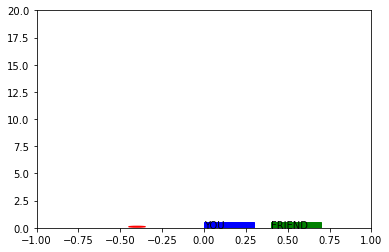

In [30]:
# Let us animate the HMM we have built
# (NOT GRADED)

from matplotlib import pyplot as plt
from matplotlib import animation, rc
from matplotlib.patches import Circle, Rectangle, Wedge

wb = WaterBalloonModel()
wb.build_hmm()
(states, evidences) = wb.sample_trace(200)



class AnimateBalloonTraj:
    def __init__(self, states, evidences): 
        fig, ax = plt.subplots()
        ax.set_xlim((-1, 1))
        ax.set_ylim((0, 20))
        self.states = states
        self.xy = [(-1.0+0.1*i, 0.1*j) for (i,j) in states]
        self.evidences = evidences
        self.patches = [
            ax.add_patch(Circle(self.xy[0], 0.05, color='red')),
            ax.add_patch(Rectangle((0,-0.5), 0.3,1.0, color='blue')),
            ax.add_patch(Rectangle((0.4,-0.5),0.3,1.0, color='green'))
        ]
        ax.text(0,0,'YOU')
        ax.text(0.4, 0, 'FRIEND')
        self.ax = ax
        self.fig = fig 
    def __call__(self, k):
        ax = self.ax 
        if k < len(self.states):
            (x,y) = self.xy[k]
        else:
            print('Out of bounds!')
            (x,y) = self.xy[-1]
        self.patches[0].center = (x,y)
        #self.patches[0].set_xy((x,y))
        return self.patches
        
abt = AnimateBalloonTraj(states, evidences)
anim = animation.FuncAnimation(abt.fig, abt, frames=200, interval=25, blit=True)
rc('animation', html='jshtml')
anim

In [31]:
print('Let us now solve a filtering problem with the following sequence of evidence:')
print(evidences[1:])
cur_belief_state = wb.initial_belief_state()
belief_states = [cur_belief_state]
for e in evidences[1:]:
    new_belief_state = wb.one_step_filter(belief_states[-1], e)
    belief_states.append(new_belief_state)

Let us now solve a filtering problem with the following sequence of evidence:
['unknown', 'unknown', 12, 12, 'unknown', 12, 'unknown', 10, 8, 9, 'unknown', 'unknown', 'unknown', 'unknown', 10, 'unknown', 8, 'unknown', 'unknown', 'unknown', 13, 'unknown', 'unknown', 10, 'unknown', 'unknown', 9, 'unknown', 13, 13, 'unknown', 9, 7, 10, 9, 'unknown', 11, 13, 10, 'unknown', 10, 'unknown', 'unknown', 11, 8, 6, 9, 'unknown', 6, 7, 6, 6, 7, 'unknown', 'unknown', 4, 6, 3, 6, 'unknown', 7, 'unknown', 'unknown', 11, 'unknown', 7, 'unknown', 3, 7, 4, 'unknown', 'unknown', 5, 1, 'unknown', 'unknown', 1, 4, 'unknown', 0, 'unknown', 2, 'unknown', 20, 'unknown', 'unknown', 20, 20, 'unknown', 0, 'unknown', 18, 'unknown', 1, 'unknown', 'unknown', 18, 18, 'unknown', 'unknown', 0, 'unknown', 'unknown', 1, 2, 3, 'unknown', 20, 18, 'unknown', 'unknown', 2, 0, 2, 'unknown', 2, 'unknown', 4, 3, 'unknown', 3, 5, 3, 3, 7, 'unknown', 4, 1, 'unknown', 'unknown', 'unknown', 'unknown', 6, 5, 'unknown', 'unknown', '

KeyboardInterrupt: 

In [ ]:
# Enjoy the animation! (NOT GRADED)

from matplotlib.collections import PatchCollection
from matplotlib import cm
import numpy as np

class AnimateBeliefStates:
    def __init__(self, states, evidence, belief_states, wb):
        fig, ax = plt.subplots()
        
        self.fig = fig
        self.ax = ax
        ax.set_xlim((-1, 1))
        ax.set_ylim((0, 20))
        #ax.set_aspect(1.0)
        self.states = states
        patches = [Rectangle((-1+0.1*i, 0.1*j), 0.1, 0.1, color=(0,0,0))
                for i in range(21)
                for j in range(201)
        ]
        self.pc = PatchCollection(patches, cmap=cm.Greys, alpha=1.0)
        ax.add_collection(self.pc)
        self.ball_patch = ax.add_patch(Circle((0,20.0),0.1, color='red'))
        self.text_patch = ax.text(0.5, 16,'Evidence:??')
        ax.add_patch(Rectangle((0,-0.5), 0.3,1.0, color='blue')),
        ax.add_patch(Rectangle((0.4,-0.5),0.3,1.0, color='green'))
        ax.text(0,-0.5,'YOU')
        ax.text(0.4, -0.5, 'FRIEND')
        self.belief_states = belief_states
        self.states = states
        self.evidence = evidence
        self.wb = wb
        
    def __call__(self, j):
        if j % 25 == 0:
            print(j)
        if j < len(self.belief_states):
            bstate = self.belief_states[j]
            ev = self.evidence[j]
            (i,j) = self.states[j]
        else:
            bstate = self.belief_states[-1]
            (i,j) = self.states[-1]
            ev = self.evidence[-1]
        xy = (-1.0+0.1*i, 0.1*j)
        ax = self.ax
        wb = self.wb
        colors = [pij for pij in bstate]
        self.pc.set_array(np.array(colors))
        self.ball_patch.center = xy
        if type(ev) == int:
            self.text_patch.set_text(f'evidence: {-1 + 0.1*ev}')
        elif ev == 'unknown':
            self.text_patch.set_text('evidence: unknown')
        return [self.pc, self.ball_patch, self.text_patch]
    
abs = AnimateBeliefStates(states, evidences, belief_states, wb)
anim = animation.FuncAnimation(abs.fig, abs, frames=200, interval=25,blit=True)
rc('animation', html='jshtml')
anim

<a id="bottom"></a>
[Back to top](#top)